<h2>Regression</h2>
<p>Regression is the problem where we want to predict the outcome of a continous value like price or a probability. In classification problem where we select a class from a list of classes (for example, identifying which color is present in the image). <br>
We are using Auto MPG dataset from online, builds a model which will predict the fuel efficiency of late 1970 and early 1980 automobiles. To achieve this, we provide the model with the description of some or all automobiles from that specified period. The description includes attributes like cylinders, displacement, horsepower and weight. We will be using tf.keras API. 

In [1]:
#Importing required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

<h3>Loading the dataset</h3>
<p>The Auto MPG dataset is avaialble in UCI Machine Learning Repository. We will download the dataset using the URL and import the dataset using pandas.</p>

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

#Specifying the column names as list
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

#Reading the csv file from url
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [3]:
dataset = raw_dataset.copy()

#It will return bottom 5 rows of dataset
dataset.tail()

MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[5 rows x 8 columns]

In [4]:
#Clearing few unknown values of the dataset
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
#Drop the above rows
dataset = dataset.dropna()

<p>In the dataset, the <b>origin</b> column is containing categorical value. We have to convert that to a one-hot with pd.get_dummies.</p>


In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [7]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  ...  Model Year  Europe  Japan  USA
393  27.0          4         140.0        86.0  ...          82       0      0    1
394  44.0          4          97.0        52.0  ...          82       1      0    0
395  32.0          4         135.0        84.0  ...          82       0      0    1
396  28.0          4         120.0        79.0  ...          82       0      0    1
397  31.0          4         119.0        82.0  ...          82       0      0    1

[5 rows x 10 columns]

<h4>Splitting the dataset</h4>
<p>We will split the dataset into train and test batches. Test batches is used in the final evaluation of the model.

In [8]:
training_dataset = dataset.sample(frac=0.8, random_state=0)
tests_dataset = dataset.drop(training_dataset.index)

<h4>Inspect the data</h4>
<p>We will look at the joint distribution of few pairs of columns from the training set. By looking at the top row, it should be clear that fuel efficiency or MPG is a function of all other parameters. By looking at the other rows, it is clear that they are functions of each other.<br>
We are using pairplot to plot the training dataset columns, which will plot pairwise relationship in a dataset.

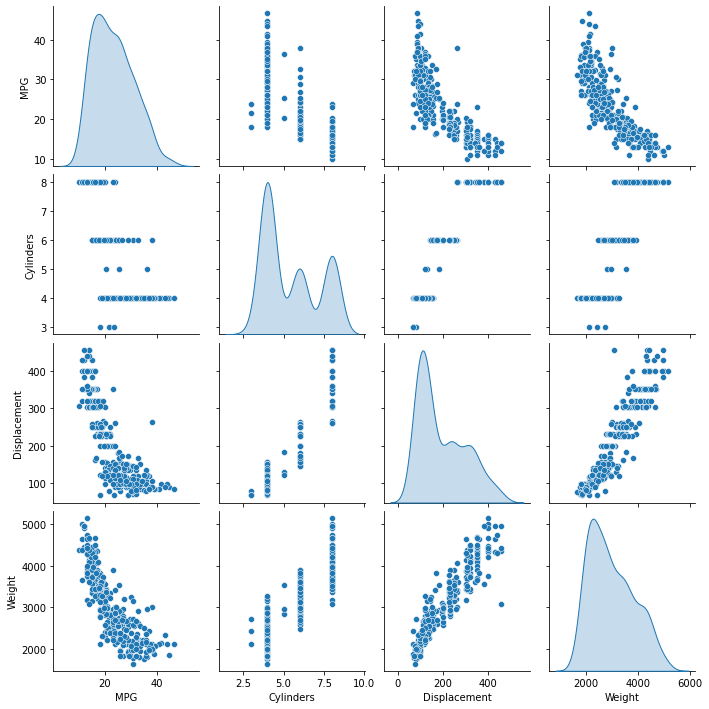

In [9]:
#Pairplot with kind of diagonal subplot kde
sns.pairplot(training_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [10]:
# Looking overall statistics. How each feature covers a very different range
training_dataset.describe().transpose()

count         mean         std  ...     50%      75%     max
MPG           314.0    23.310510    7.728652  ...    22.0    28.95    46.6
Cylinders     314.0     5.477707    1.699788  ...     4.0     8.00     8.0
Displacement  314.0   195.318471  104.331589  ...   151.0   265.75   455.0
Horsepower    314.0   104.869427   38.096214  ...    94.5   128.00   225.0
Weight        314.0  2990.251592  843.898596  ...  2822.5  3608.00  5140.0
Acceleration  314.0    15.559236    2.789230  ...    15.5    17.20    24.8
Model Year    314.0    75.898089    3.675642  ...    76.0    79.00    82.0
Europe        314.0     0.178344    0.383413  ...     0.0     0.00     1.0
Japan         314.0     0.197452    0.398712  ...     0.0     0.00     1.0
USA           314.0     0.624204    0.485101  ...     1.0     1.00     1.0

[10 rows x 8 columns]

<h4>Split features from labels</h4>
<p>We will seperate the target value, the 'label' from the features. This label is the value that we will train the model to predict. So, it should be removed.</p>


In [11]:
training_features = training_dataset.copy()
tests_features = tests_dataset.copy()

training_labels = training_features.pop('MPG')
tests_labels = tests_features.pop('MPG')

<h3>Normalization</h3>
<p>Normalization is the process of shifting the values so that they are ended up in between 0 and 1. It is easy to form the statisyic table and see the different ranges of each feature. </p>


In [12]:
#Calculating mean and SD for each column
training_dataset.describe().transpose()[['mean', 'std']]

mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
Europe           0.178344    0.383413
Japan            0.197452    0.398712
USA              0.624204    0.485101

<p>Sometimes it is good to normalize features that use different scales and ranges. The normalization is important because the feature are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.<br>
Although the model may converge without feature normalization, the normalization makes the training process much more stable.</p>

<h4>Normalization layer</h4>
<p>The preprocessing layer called <b>preprocessing.Normalization </b> is clean and simple way to build in the model. At first we create the normalization layer.</p>

In [13]:
#Creating normalization layer
normalizer = preprocessing.Normalization()

In [14]:
#Adapting the layer to the data
normalizer.adapt(np.array(training_features))

In [15]:
#Calculating the mean and variance, they are stored in this layer
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [16]:
#Calling the normalization layer, it will display each feature with normalized value
first = np.array(training_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


<h3>Linear regression</h3>
<p>Linear regression is the algorithm based on supervised learning where the number of independent variable is one and there is a linear relationship between independent and dependent variable.</p>
<h4>Linear regression with one variable</h4>
<p>Let's start with the simple one linear regression with one variable. Here we will predict the MPG from Horsepower. We will start with defining the architecture of the model then the model is trained with tf.keras. <br>
We are using Sequential model of keras where the model is represented by sequence of steps. Model to be built has two steps:</p>
<ul><li>Normalize the input Weight</li>
<li>Apply linear transformation i.e <i>y = mx + b</i>. This will produce output 1 using layers.Dense.</li></ul>
<p>The number of inputs can either be specified by the input_shape arguement, or automatically when the model is run for the first time.

In [17]:
#At first we create a horsepower normalization layer
horsepower = np.array(training_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [18]:
#Build the sequential model with horsepower_normalizer 
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])


#Displaying the summary of the model
horsepower_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


<p>We are running the untrained model on the first 10 weight values. The output is not good, but we will see the expected shape (10,1).</p>

In [19]:
horsepower_model.predict(horsepower[:10])

array([[ 0.64 ],
       [ 0.361],
       [-1.18 ],
       [ 0.896],
       [ 0.811],
       [ 0.318],
       [ 0.961],
       [ 0.811],
       [ 0.211],
       [ 0.361]], dtype=float32)

<p>When model is built, configure the training procedure using model.compile() method. The important arguements of model.compile() are the optimizer and the loss. We will be using 'mean_absolute_error' loss and 'adam' optimizer. 

In [20]:
#Compiling the horsepower_model
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [21]:
#Training the horsepower_model with fit() function
%%time
history = horsepower_model.fit(
    training_features['Horsepower'], training_labels,
    epochs=100,

    # suppress logging
    verbose=0,

    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 9.15 s, sys: 284 ms, total: 9.43 s
Wall time: 9.3 s


In [22]:
#Visualizing the training process by history variable which contains all the stats of training 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  val_loss  epoch
95  3.802696  4.207527     95
96  3.804470  4.196311     96
97  3.802975  4.195494     97
98  3.804382  4.200304     98
99  3.805624  4.182544     99

In [23]:
# Defining the function to plot the history of training process
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

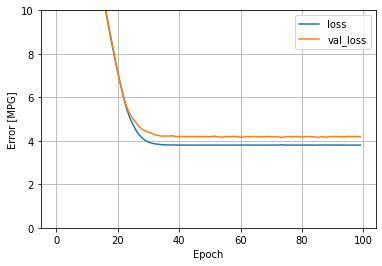

In [24]:
# Calling the plot function with history arguement
plot_loss(history)

In [25]:
#Collecting the test results which will be used later
tests_results = {}

tests_results['horsepower_model'] = horsepower_model.evaluate(
    tests_features['Horsepower'],
    tests_labels, verbose=0)

<p>Since this is a one variable regression it is easy to predict the model's prediction as function of the input.</p>

In [26]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [27]:
#Defining the function for plotting the horsepower
def plot_horsepower(x, y):
  plt.scatter(training_features['Horsepower'], training_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

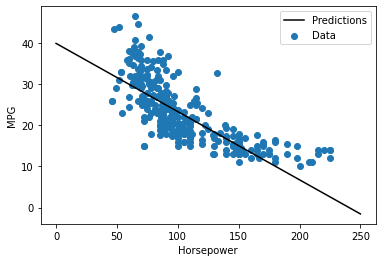

In [28]:
#calling the plot_horsepower function
plot_horsepower(x,y)

<h4>Linear regression with multiple inputs</h4>
<p>In this type of regression, we use an identical step to make predictions based on multiple inputs. The model to be built is same <i>Y = mX + b</i>, but m is a matrix and b is a vector. The first stage which is creating normalization layer is built on whole dataset.</p>

In [29]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

#When you call the above model on a batch, it produces output units = 1 for each example

In [30]:
linear_model.predict(training_features[:10])

array([[ 0.553],
       [ 0.71 ],
       [ 0.166],
       [ 1.323],
       [ 0.796],
       [ 0.305],
       [ 0.605],
       [-2.676],
       [-0.112],
       [-0.061]], dtype=float32)

<p>When the model is called it's weight matrices will be built. Now we can see that the kernel (which is y = mx + b) has a shape (9, 1).</b>

In [31]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.731],
       [ 0.581],
       [-0.114],
       [ 0.042],
       [-0.549],
       [ 0.316],
       [-0.665],
       [ 0.523],
       [ 0.466]], dtype=float32)>

In [32]:
#Compiling the model with same attributes as the previous model
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [33]:
# Train the model with fit() function with 100 epochs
%%time
history = linear_model.fit(
    training_features, training_labels, 
    epochs=100,

    # suppress logging
    verbose=0,

    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 8.84 s, sys: 203 ms, total: 9.04 s
Wall time: 8.81 s


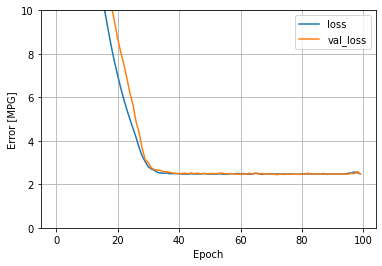

In [34]:
# Using multiple inputs achieves a much lower training and validation error compared to one input model
# As we see the result in the graph
# Plotting the loss of the history
plot_loss(history)

In [35]:
#Save the test results in the list for later use
tests_results['linear_model'] = linear_model.evaluate(
    tests_features, tests_labels, verbose=0)

<h3>DNN regression </h3>
<p>Deep Neural Network (DNN) regression is same as the linear regression but it contains hidden layers in between input and output layer. These hidden layers are non-linear layers and they are not directly connected to the inputs or outputs. This DNN regression is also implemented the models with one and multiple inputs. We discuss these one by one. DNN models will contain a few more layers than the linear model, the layers are:</p>
<ul><li>The Normalization layer</li>
<li>Two hidden, non-linear, Dense layers using relu nonlinearity</li>
<li>A single-output layer</li></ul>
<p>Both linear and DNN model use the same training procedure so the compile method is included in the build_and_copile_model() function.

In [36]:
# Function will build the model and compile the DNN model 
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

<h4>DNN regression for one variable</h4>
<p>The single input here using is HorsePower (same used in Linear regression).</p>


In [37]:
#Building and compiling the model for horspower input
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [38]:
# This model has few more trainable parameter than linear model, we see it by displaying the summary of the model
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [39]:
#Training the model with 100 epochs
%%time
history = dnn_horsepower_model.fit(
    training_features['Horsepower'], training_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.08 s, sys: 230 ms, total: 9.31 s
Wall time: 8.97 s


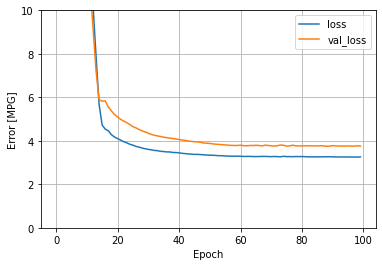

In [40]:
#Plotting the history of DNN regression for horsepower input
plot_loss(history)

#This model looks like better than linear model for horsepower input

<p>By plotting the predictions as a function of Horsepower, we will see this model takes advantage of non-linearity provided by the hidden layers of DNN.</p>

In [41]:
# Defining x and y 
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

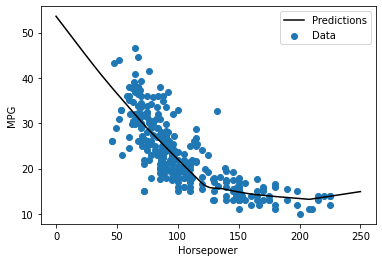

In [42]:
#Plot the horsepower model by passing x and y values
plot_horsepower(x, y)

In [43]:
# Collecting the test results of the model for later use.
tests_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    tests_features['Horsepower'], tests_labels,
    verbose=0)

<h4>DNN regression for multiple inputs</h4>
<p>Here we are passing the inputs to the model to predict the efficiency. It slightly improves the performance on the validation dataset.</p>

In [44]:
#Build and compile the model for multiple inputs
dnn_model = build_and_compile_model(normalizer)

#Displaying the summary of the model
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [45]:
#Training the model with 100 epochs
%%time
history = dnn_model.fit(
    training_features, training_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.23 s, sys: 245 ms, total: 9.47 s
Wall time: 9.08 s


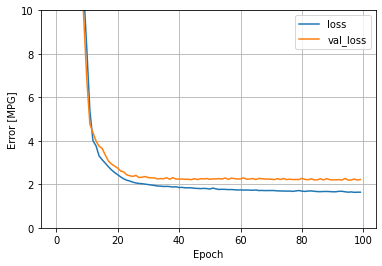

In [46]:
#Plotting the loss for the history variable
plot_loss(history)

In [47]:
# Collecting the test results of the model for later use.
tests_results['dnn_model'] = dnn_model.evaluate(tests_features,
                              tests_labels,verbose=0)

<h3>Performance</h3>
<p>We completed training process for all the 4 models. Next step is to check the test-set performance and we see how they did.</p>


In [48]:
#Adding tests_results to the dataframe
pd.DataFrame(tests_results, index=['Mean absolute error [MPG]']).T

#These below results match the validation error seen during training

Mean absolute error [MPG]
horsepower_model                       3.655300
linear_model                           2.459727
dnn_horsepower_model                   2.900929
dnn_model                              1.673322

<h4>Make predictions</h4>
<p>Prediction will have a look at the errors made by the model when making predictions on the test set. This is the final stage.</p>

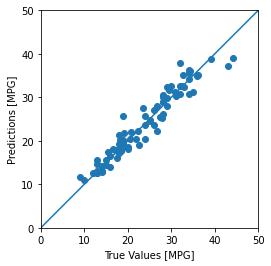

In [49]:
#Flattening the predictions of dnn model
tests_predictions = dnn_model.predict(tests_features).flatten()

#Plotting scatter plot for true and predicted values of MPG using plt variable
a = plt.axes(aspect='equal')
plt.scatter(tests_labels, tests_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#By seeing the below graph the model prediction is good 

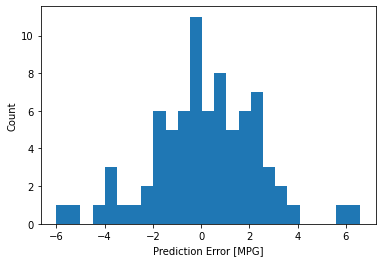

In [50]:
#plotting the histogram for error distributions
error = tests_predictions - tests_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [51]:
# Save the model if you are happy with the results
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [52]:
#Reloading the model and checking the output
reloaded = tf.keras.models.load_model('dnn_model')

tests_results['reloaded'] = reloaded.evaluate(
    tests_features, tests_labels, verbose=0)

In [53]:
# Converting tests_results to dataframe
pd.DataFrame(tests_results, index=['Mean absolute error [MPG]']).T

Mean absolute error [MPG]
horsepower_model                       3.655300
linear_model                           2.459727
dnn_horsepower_model                   2.900929
dnn_model                              1.673322
reloaded                               1.673322